In [72]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from collections import Counter

# 2. Load and preprocess data
X_train = pd.read_csv('data/umist_cropped.csv')
X_scaled = (X_train + 1) / 2  # Scale to [0,1]
X_train_scaled = X_scaled.values  # Convert to numpy array

# 3. Dimension reduction
# PCA
pca = PCA(n_components=0.995, random_state=123)
X_train_pca = pca.fit_transform(X_train_scaled)
print("Data form after PCA:", X_train_pca.shape)

# UMAP
umap_reducer = umap.UMAP(n_components=10, random_state=123)
X_umap = umap_reducer.fit_transform(X_train_scaled)
print("Data form after UMAP:", X_umap.shape)

Data form after PCA: (600, 415)


c:\Users\danie\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Data form after UMAP: (600, 10)


In [73]:
# 4. Find optimal parameters
eps_values = [0.01,0.3,.5]
min_samples_values = [7, 10]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_umap)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            score = silhouette_score(X_umap, labels)
        else:
            score = 0
            
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': score,
            'labels': labels
        })
        
        print(f"eps={eps}, min_samples={min_samples}: clusters={n_clusters}, noise={n_noise}, silhouette={score:.3f}")

# 5. Get best parameters
best_result = max(results, key=lambda x: x['silhouette'])
print("\nBest parameters found:")
print(f"eps: {best_result['eps']}")
print(f"min_samples: {best_result['min_samples']}")
print(f"Number of clusters: {best_result['n_clusters']}")
print(f"Number of noise points: {best_result['n_noise']}")
print(f"Silhouette score: {best_result['silhouette']:.3f}")

eps=0.01, min_samples=7: clusters=0, noise=600, silhouette=0.000
eps=0.01, min_samples=10: clusters=0, noise=600, silhouette=0.000
eps=0.3, min_samples=7: clusters=27, noise=249, silhouette=0.085
eps=0.3, min_samples=10: clusters=13, noise=423, silhouette=-0.158
eps=0.5, min_samples=7: clusters=14, noise=11, silhouette=0.243
eps=0.5, min_samples=10: clusters=16, noise=71, silhouette=0.286

Best parameters found:
eps: 0.5
min_samples: 10
Number of clusters: 16
Number of noise points: 71
Silhouette score: 0.286


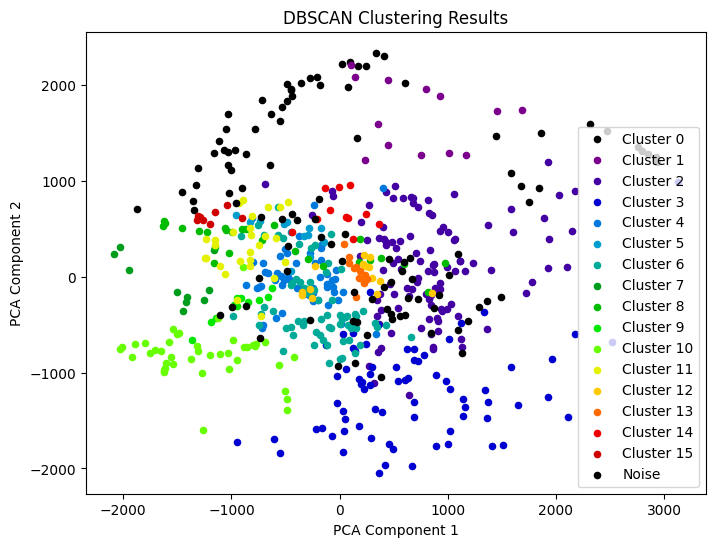

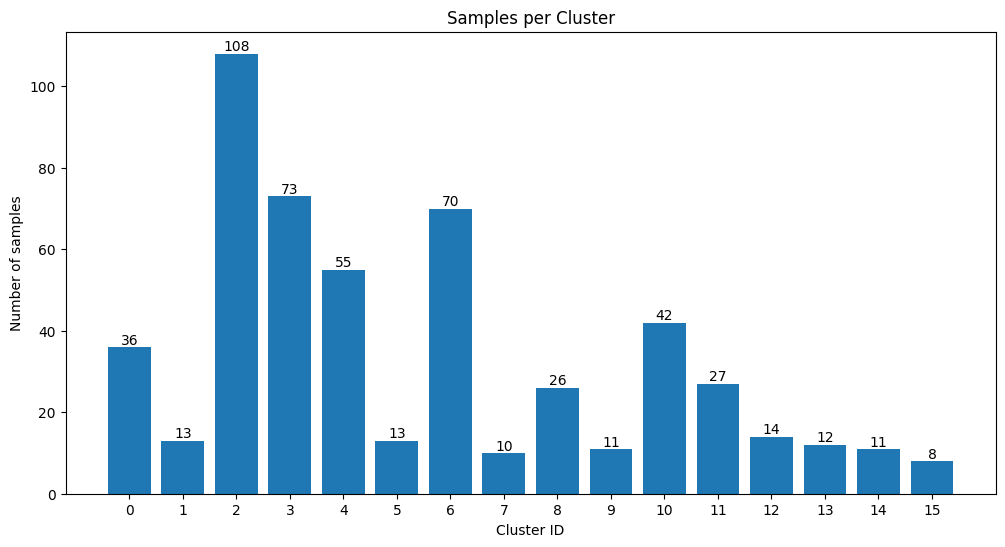

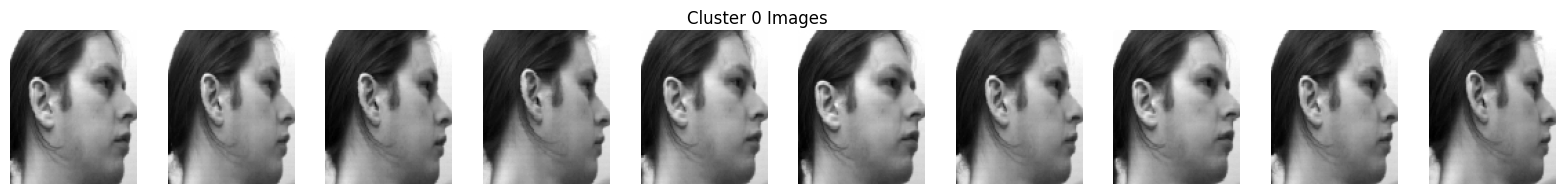

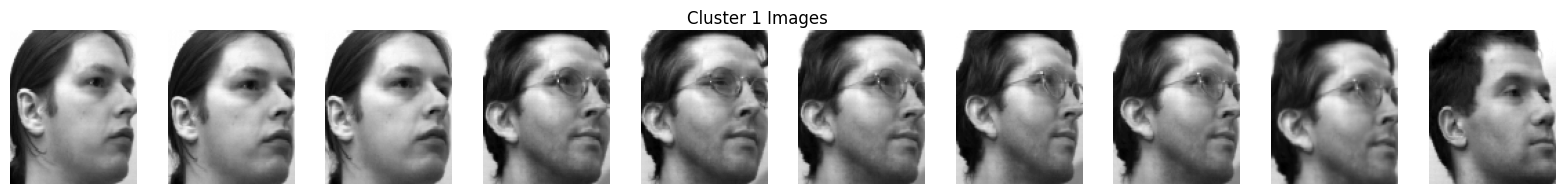

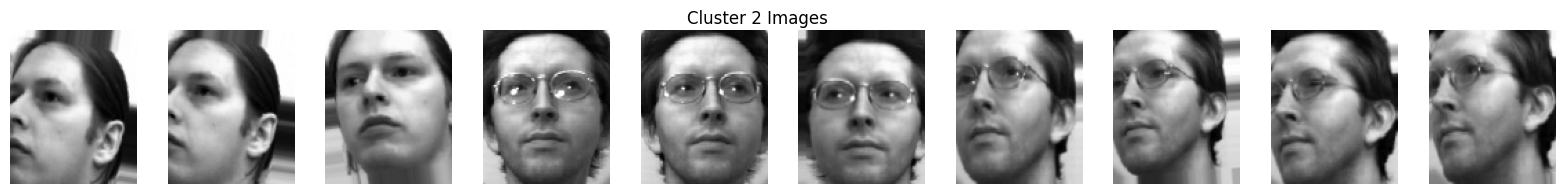

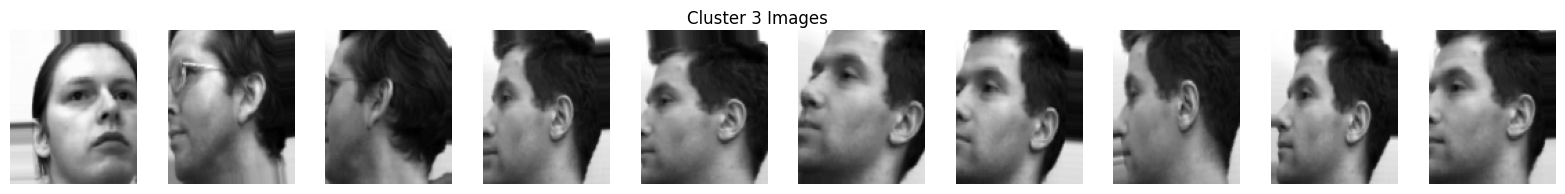

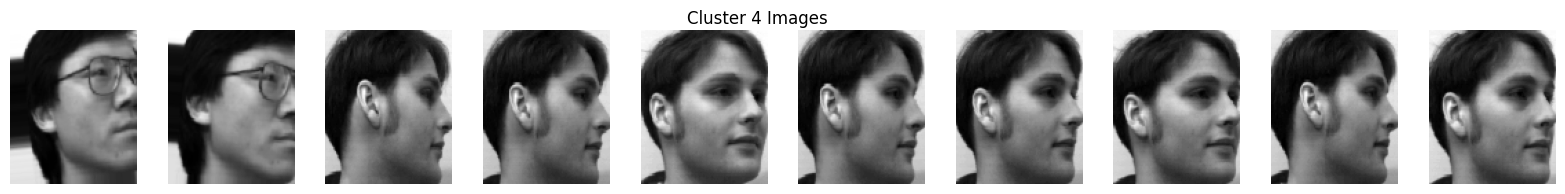

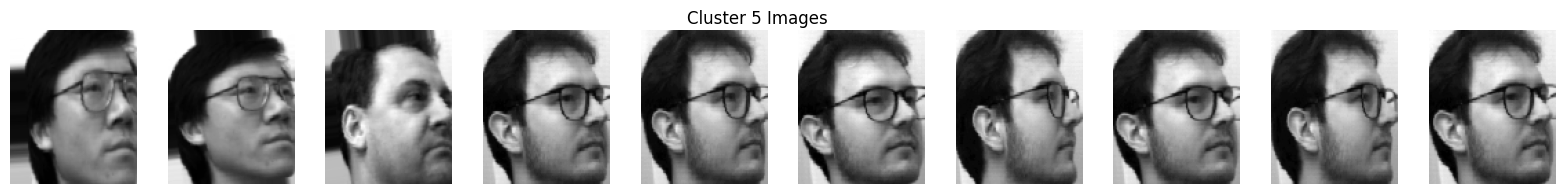

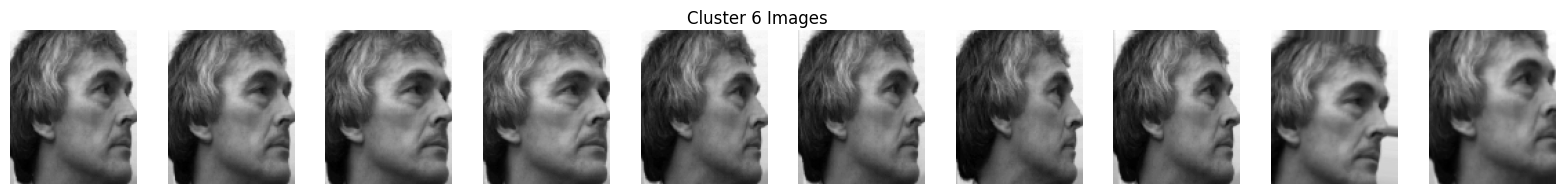

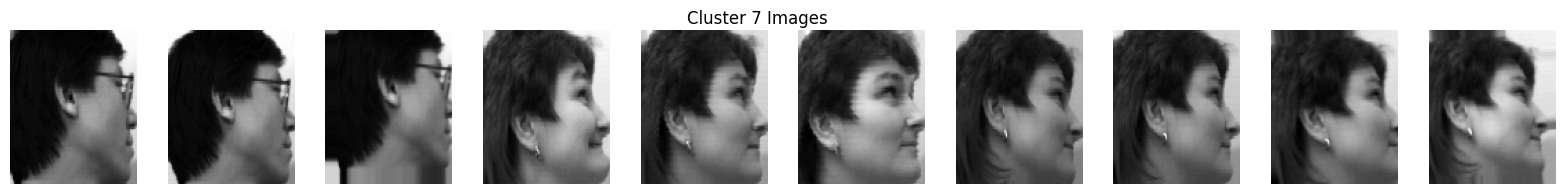

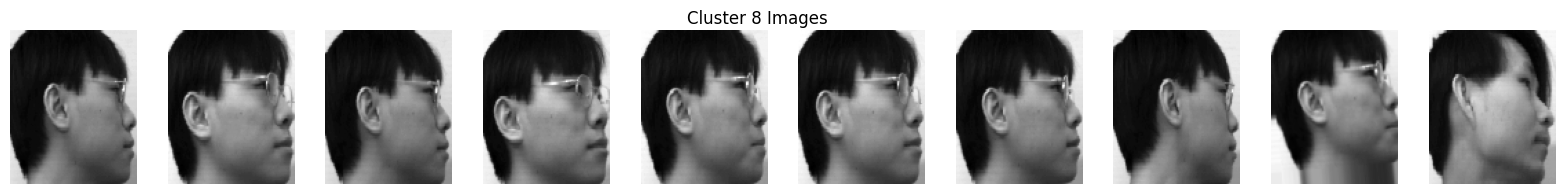

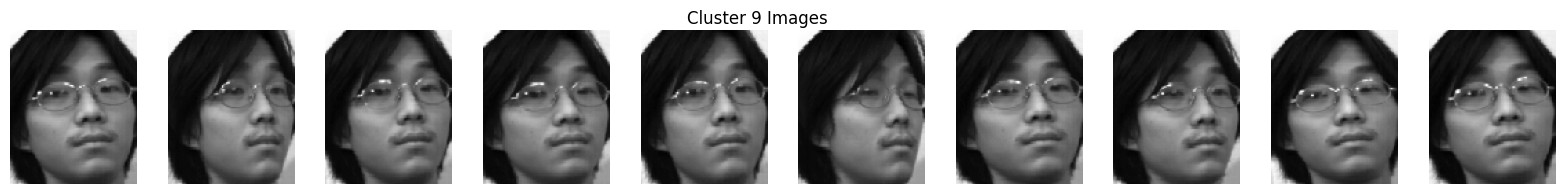

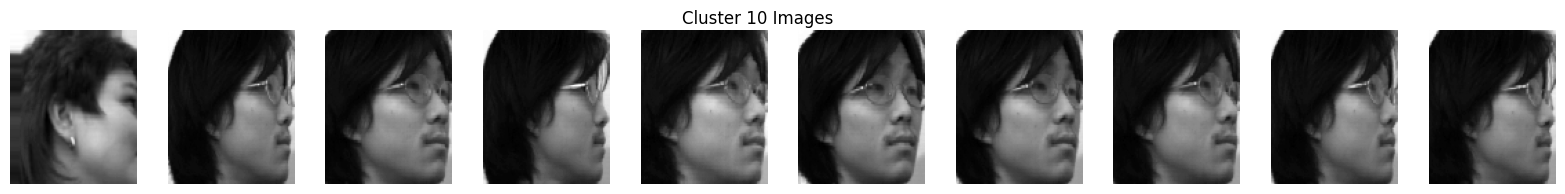

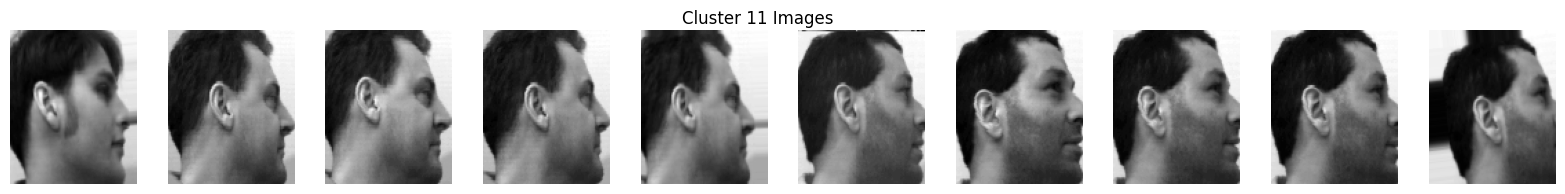

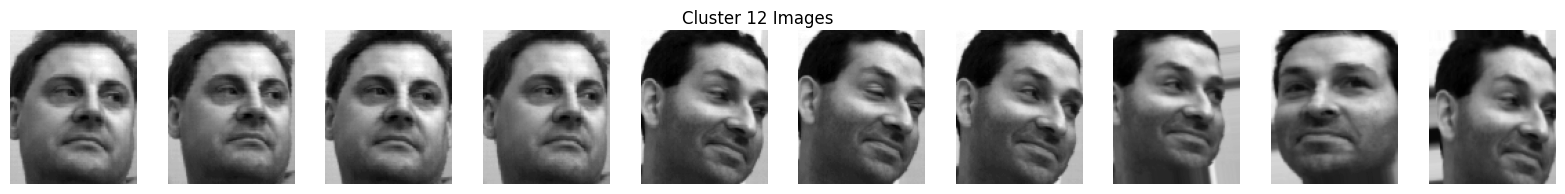

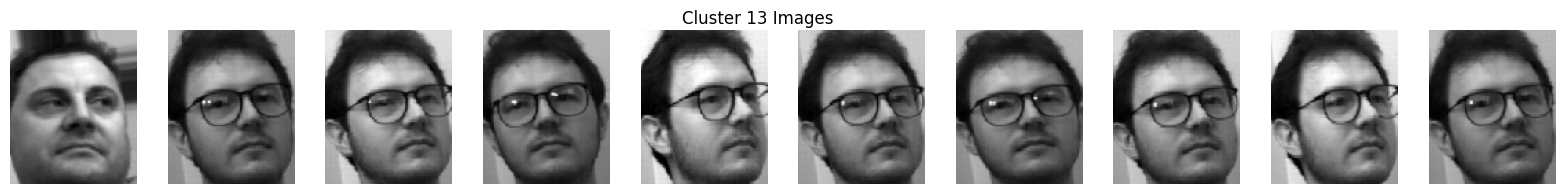

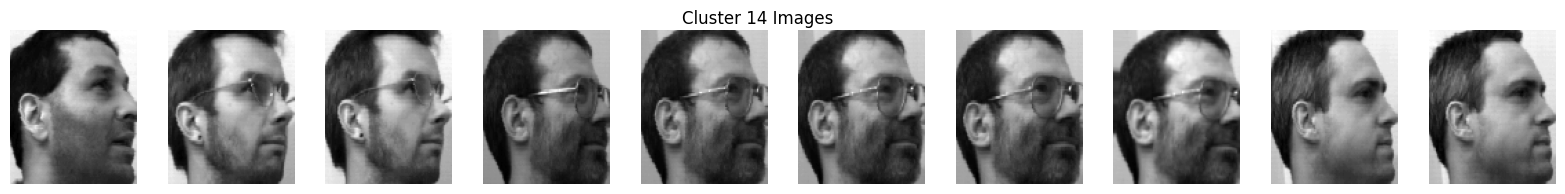

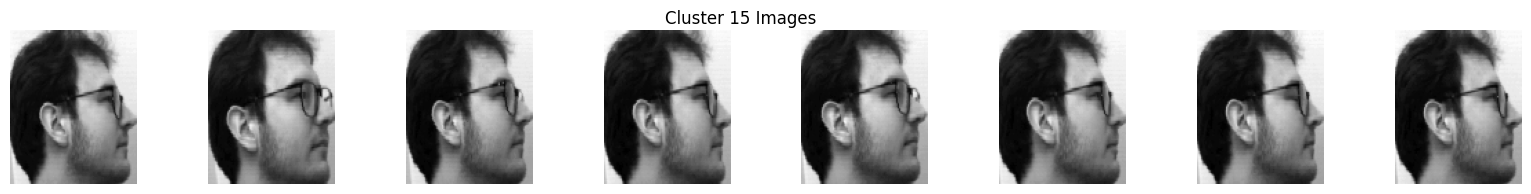


Cluster distribution:
Noise points (-1): 71
Cluster 0: 36 samples
Cluster 1: 13 samples
Cluster 2: 108 samples
Cluster 3: 73 samples
Cluster 4: 55 samples
Cluster 5: 13 samples
Cluster 6: 70 samples
Cluster 7: 10 samples
Cluster 8: 26 samples
Cluster 9: 11 samples
Cluster 10: 42 samples
Cluster 11: 27 samples
Cluster 12: 14 samples
Cluster 13: 12 samples
Cluster 14: 11 samples
Cluster 15: 8 samples


In [74]:
# 6. Visualize clustering results
labels = best_result['labels']

# Scatter plot
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels)))

for label, col in zip(unique_labels, colors):
    if label == -1:
        col = 'black'
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'
    
    mask = (labels == label)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
               c=[col], label=label_name, s=20)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering Results')
plt.legend()
plt.show()

# Bar plot of cluster sizes
cluster_distribution = Counter(labels)
if -1 in cluster_distribution:
    del cluster_distribution[-1]

plt.figure(figsize=(12, 6))
plt.bar(cluster_distribution.keys(), cluster_distribution.values())
plt.xlabel('Cluster ID')
plt.ylabel('Number of samples')
plt.title('Samples per Cluster')
plt.xticks(range(len(cluster_distribution)))

for i, v in cluster_distribution.items():
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# 7. Display images for each cluster
for cluster_id in range(best_result['n_clusters']):
   # Get indices of images in current cluster
   cluster_indices = np.where(labels == cluster_id)[0]
   
   # Get number of images to display (max 10)
   num_images = min(10, len(cluster_indices))
   
   if num_images > 0:
       fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
       fig.suptitle(f'Cluster {cluster_id} Images')
       
       for i in range(num_images):
           # Get original image data
           image_data = X_train_scaled[cluster_indices[i]].reshape(112, 92)
           
           if num_images == 1:
               axes.imshow(image_data, cmap='gray')
               axes.axis('off')
           else:
               axes[i].imshow(image_data, cmap='gray')
               axes[i].axis('off')
       plt.show()


# Print final distribution
print("\nCluster distribution:")
print("Noise points (-1):", Counter(labels)[-1])
for cluster_id in sorted(cluster_distribution.keys()):
    print(f"Cluster {cluster_id}: {cluster_distribution[cluster_id]} samples")

In [75]:
# 5. 최적의 eps 및 min_samples 찾기
# 새로운 코드
eps_values = [0.1, 0.15, 0.2, 0.25, 0.3]  # 더 작은 범위
min_samples_values = [3, 5, 7, 10]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_umap)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            score = silhouette_score(X_umap, labels)
        else:
            score = 0
            
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': score,
            'labels': labels
        })

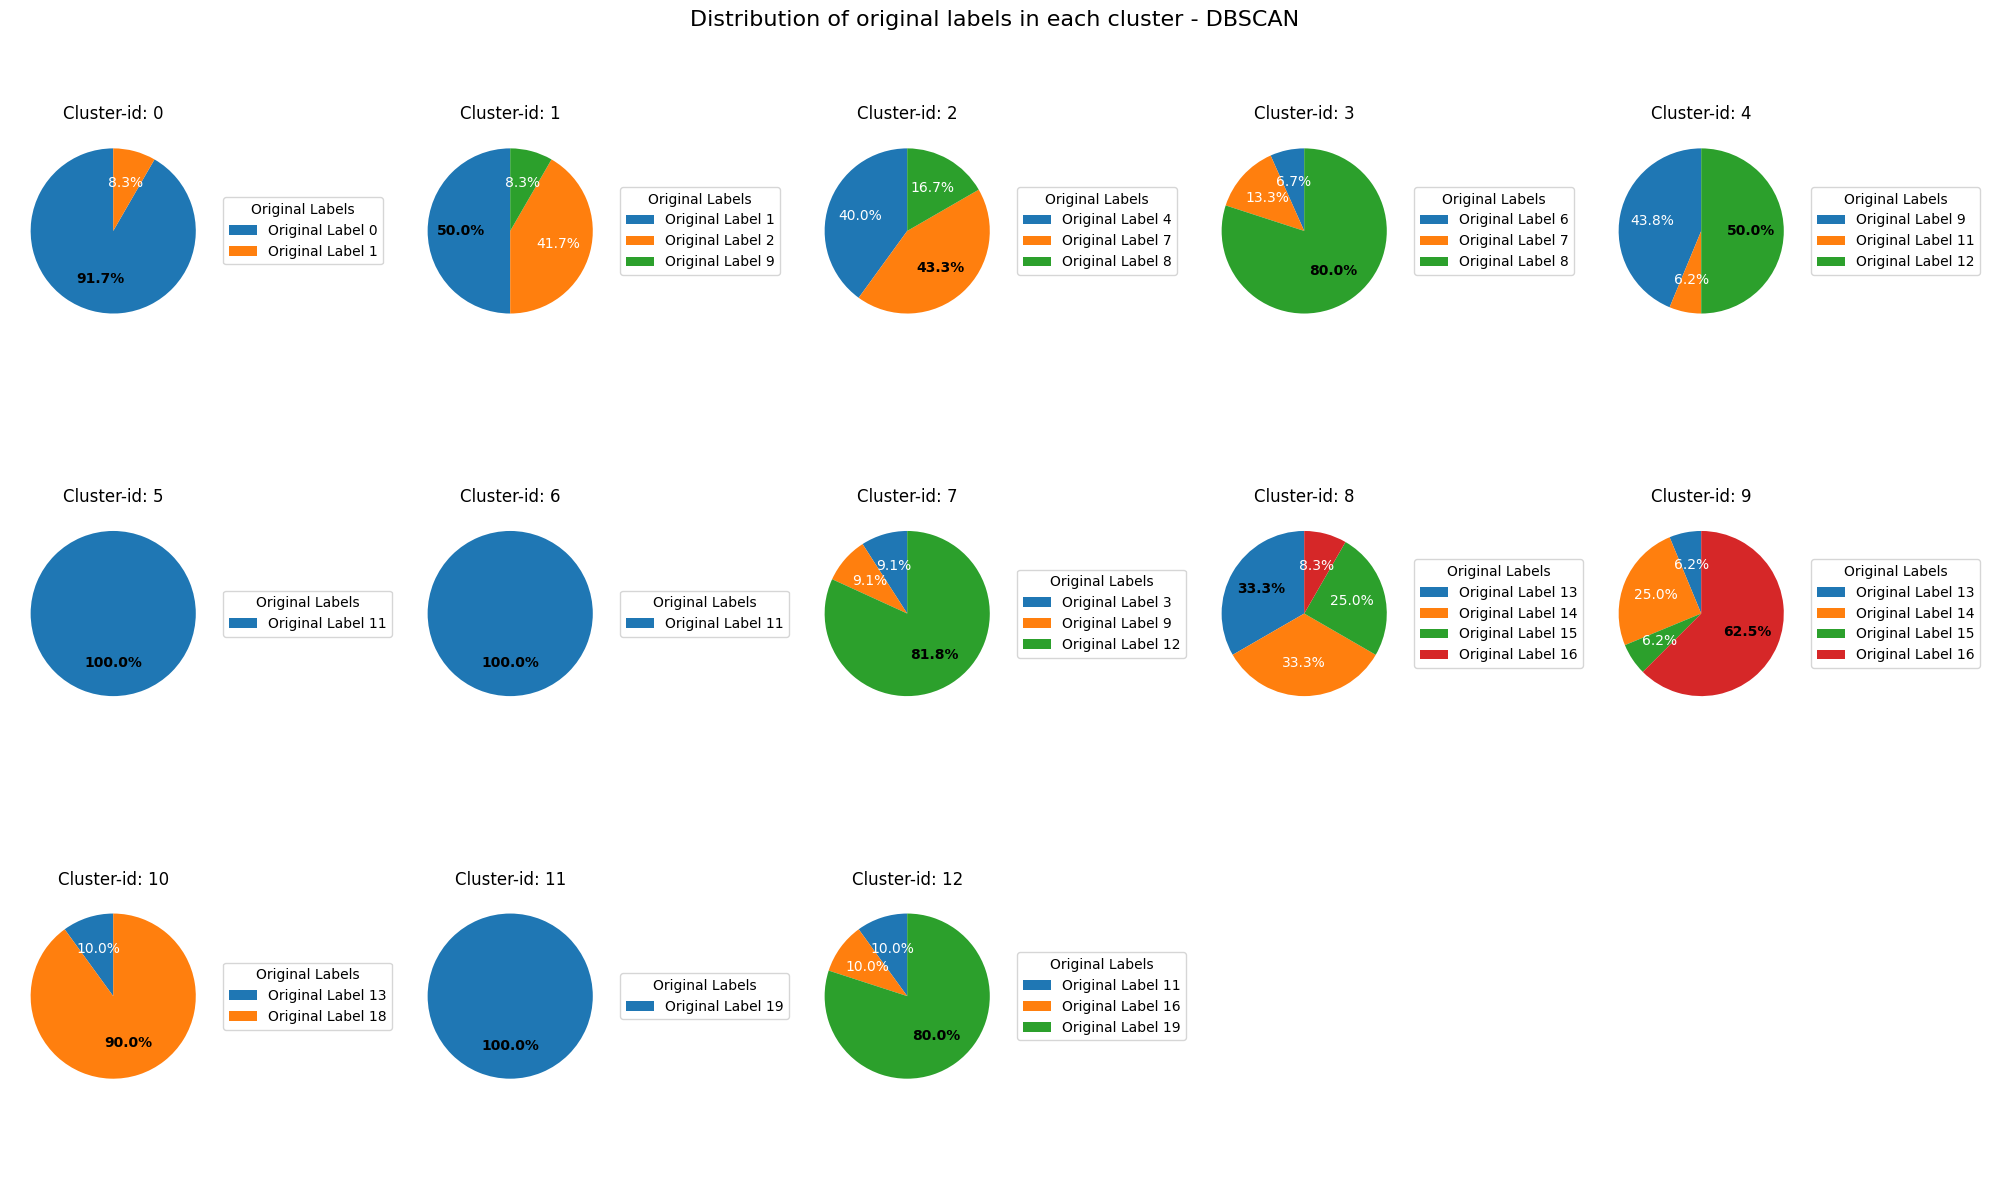


Detailed cluster compositions:

Cluster 0:
  Original label 0: 11 images (91.7%)
  Original label 1: 1 images (8.3%)

Cluster 1:
  Original label 1: 6 images (50.0%)
  Original label 2: 5 images (41.7%)
  Original label 9: 1 images (8.3%)

Cluster 2:
  Original label 7: 13 images (43.3%)
  Original label 4: 12 images (40.0%)
  Original label 8: 5 images (16.7%)

Cluster 3:
  Original label 8: 12 images (80.0%)
  Original label 7: 2 images (13.3%)
  Original label 6: 1 images (6.7%)

Cluster 4:
  Original label 12: 8 images (50.0%)
  Original label 9: 7 images (43.8%)
  Original label 11: 1 images (6.2%)

Cluster 5:
  Original label 11: 10 images (100.0%)

Cluster 6:
  Original label 11: 10 images (100.0%)

Cluster 7:
  Original label 12: 9 images (81.8%)
  Original label 3: 1 images (9.1%)
  Original label 9: 1 images (9.1%)

Cluster 8:
  Original label 13: 4 images (33.3%)
  Original label 14: 4 images (33.3%)
  Original label 15: 3 images (25.0%)
  Original label 16: 1 images (8.3%)

In [76]:
# 분포 시각화를 위한 코드 추가 (기존 코드 뒤에 추가)
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Original labels (assuming 30 images per person)
original_labels = np.repeat(range(20), 30)

# Function for percentage formatting
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 5 else ''

# Get unique cluster labels (excluding noise points)
unique_clustered_labels = sorted(list(set(labels)))
if -1 in unique_clustered_labels:
    unique_clustered_labels.remove(-1)

# Calculate needed rows for subplots (5 columns)
n_rows = int(np.ceil(len(unique_clustered_labels) / 5))

# Create subplots
fig, axes = plt.subplots(n_rows, 5, figsize=(20, 4*n_rows))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Convert to list if only one row

# Create pie chart for each cluster
for i, cluster_label in enumerate(unique_clustered_labels):
    cluster_mask = labels == cluster_label
    cluster_orig_labels = original_labels[cluster_mask]
    
    # Count original labels in this cluster
    label_counts = Counter(cluster_orig_labels)
    
    # Prepare data for pie chart
    values = list(label_counts.values())
    label_names = [f'{k}' for k in label_counts.keys()]
    
    # Create pie chart
    wedges, texts, autotexts = axes[i].pie(values, 
                                          labels=label_names,
                                          autopct=autopct_format,
                                          textprops={'color': "w"},
                                          startangle=90)
    
    # Highlight largest segment
    if values:
        max_idx = np.argmax(values)
        autotexts[max_idx].set_color('black')
        autotexts[max_idx].set_fontweight('bold')
    
    axes[i].set_title(f'Cluster-id: {cluster_label}')
    
    # Add legend
    axes[i].legend(wedges, [f'Original Label {l}' for l in label_counts.keys()],
                  title="Original Labels",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))

# Turn off unused subplots
for j in range(len(unique_clustered_labels), len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of original labels in each cluster - DBSCAN', fontsize=16)
plt.tight_layout()
plt.show()

# Print detailed cluster compositions
print("\nDetailed cluster compositions:")
for cluster in unique_clustered_labels:
    cluster_mask = labels == cluster
    cluster_orig_labels = original_labels[cluster_mask]
    composition = Counter(cluster_orig_labels)
    
    print(f"\nCluster {cluster}:")
    total = sum(composition.values())
    for orig_label, count in composition.most_common():
        percentage = (count / total) * 100
        print(f"  Original label {orig_label}: {count} images ({percentage:.1f}%)")